<font size="+3"><strong>Earthquake Damage In Gorkha🇳🇵 </strong></font>

<font size="+2"><strong>Part 2: Predicting Damage with Logistic Regression</strong></font>

In [1]:
__author__ = "Donald Ghazi"
__email__ = "donald@donaldghazi.com"
__website__ = "donaldghazi.com"

In [2]:
import sqlite3
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

In the `Wrangling Data with SQL` project, I was able to pull that Nepal building data out of my database. And now I'm going to do more cleaning and prepare it to build a classification model.

Logistic Regression

GOALS
 - Prepare dataset for binary classification. 
 - Create a logistic regression model to predict severe damage.
 - Explain model predictions using odds ratio.

Machine Learning Workflow
 - Prepare Data
     - Import: Binary target
     - Explore: Class balance
     - Split: Randomized train-test split
 - Build Model
     - Baseline: Accuracy score
     - Iterate: Logistic regression (for classification)
     - Evaluate: Accuracy score 
 - Communicate Results
     - Odds ratio

# Prepare Data

## Import 

In [3]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")

    return df

In [4]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
b_id,,,,,,,,,,,,,,,,,
164002,164002,3,3,20,560,18,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Repaired and used,"Stone, mud mortar",Grade 2
164081,164081,2,2,21,200,12,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 2
164089,164089,3,3,18,315,20,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 2
164098,164098,2,2,45,290,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 3
164103,164103,2,2,21,230,13,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 3


There seem to be several features in `df` with information about the condition of a property after the earthquake.

Now I need to add to my wrangle function so that these features are dropped from the DataFrame.

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   count_floors_post_eq    70836 non-null  int64 
 3   age_building            70836 non-null  int64 
 4   plinth_area_sq_ft       70836 non-null  int64 
 5   height_ft_pre_eq        70836 non-null  int64 
 6   height_ft_post_eq       70836 non-null  int64 
 7   land_surface_condition  70836 non-null  object
 8   foundation_type         70836 non-null  object
 9   roof_type               70836 non-null  object
 10  ground_floor_type       70836 non-null  object
 11  other_floor_type        70836 non-null  object
 12  position                70836 non-null  object
 13  plan_configuration      70836 non-null  object
 14  condition_post_eq       70836 non-null  object
 

In [6]:
drop_cols = []
for col in df.columns:
    print(col)

drop_cols

building_id
count_floors_pre_eq
count_floors_post_eq
age_building
plinth_area_sq_ft
height_ft_pre_eq
height_ft_post_eq
land_surface_condition
foundation_type
roof_type
ground_floor_type
other_floor_type
position
plan_configuration
condition_post_eq
superstructure
damage_grade


[]

In [7]:
drop_cols = []
for col in df.columns:
    if "post_eq" in col:
        print(col)

drop_cols

count_floors_post_eq
height_ft_post_eq
condition_post_eq


[]

In [8]:
drop_cols = []
for col in df.columns:
    if "post_eq" in col:
        drop_cols.append(col)

drop_cols

['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [9]:
drop_cols = []

drop_cols

[]

In [10]:
drop_cols = [col for col in df.columns]

drop_cols

['building_id',
 'count_floors_pre_eq',
 'count_floors_post_eq',
 'age_building',
 'plinth_area_sq_ft',
 'height_ft_pre_eq',
 'height_ft_post_eq',
 'land_surface_condition',
 'foundation_type',
 'roof_type',
 'ground_floor_type',
 'other_floor_type',
 'position',
 'plan_configuration',
 'condition_post_eq',
 'superstructure',
 'damage_grade']

In [11]:
drop_cols = [col for col in df.columns if "post_eq" in col]

drop_cols

['count_floors_post_eq', 'height_ft_post_eq', 'condition_post_eq']

In [12]:
# Write a wrangle function so that the it returns the results of query as a DataFrame

def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")   # Set index column to "b_id"
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)

    return df

In [13]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,damage_grade
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 2
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 3
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",Grade 3


In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   age_building            70836 non-null  int64 
 3   plinth_area_sq_ft       70836 non-null  int64 
 4   height_ft_pre_eq        70836 non-null  int64 
 5   land_surface_condition  70836 non-null  object
 6   foundation_type         70836 non-null  object
 7   roof_type               70836 non-null  object
 8   ground_floor_type       70836 non-null  object
 9   other_floor_type        70836 non-null  object
 10  position                70836 non-null  object
 11  plan_configuration      70836 non-null  object
 12  superstructure          70836 non-null  object
 13  damage_grade            70836 non-null  object
dtypes: int64(5), object(9)
memory usage: 8.1+ MB
Non

I want to build a **binary classification** model, but my current target `"damage_grade"` has more than two categories.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70836 entries, 164002 to 234835
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   building_id             70836 non-null  int64 
 1   count_floors_pre_eq     70836 non-null  int64 
 2   age_building            70836 non-null  int64 
 3   plinth_area_sq_ft       70836 non-null  int64 
 4   height_ft_pre_eq        70836 non-null  int64 
 5   land_surface_condition  70836 non-null  object
 6   foundation_type         70836 non-null  object
 7   roof_type               70836 non-null  object
 8   ground_floor_type       70836 non-null  object
 9   other_floor_type        70836 non-null  object
 10  position                70836 non-null  object
 11  plan_configuration      70836 non-null  object
 12  superstructure          70836 non-null  object
 13  damage_grade            70836 non-null  object
dtypes: int64(5), object(9)
memory usage: 8.1+ MB


In [16]:
df["damage_grade"].head()

b_id
164002    Grade 2
164081    Grade 2
164089    Grade 2
164098    Grade 3
164103    Grade 3
Name: damage_grade, dtype: object

In [17]:
df["damage_grade"].value_counts()

Grade 5    24869
Grade 4    20650
Grade 3    14097
Grade 2     7650
Grade 1     3570
Name: damage_grade, dtype: int64

In [18]:
df["damage_grade"].str[-1].head()

b_id
164002    2
164081    2
164089    2
164098    3
164103    3
Name: damage_grade, dtype: object

In [19]:
df["damage_grade"].str[-1].astype(int).head()

b_id
164002    2
164081    2
164089    2
164098    3
164103    3
Name: damage_grade, dtype: int64

In [20]:
df["damage_grade"] = df["damage_grade"].str[-1].astype(int)

In [21]:
(df["damage_grade"] > 3).head(10)

b_id
164002    False
164081    False
164089    False
164098    False
164103    False
164186     True
164204     True
164205     True
164211     True
164220     True
Name: damage_grade, dtype: bool

In [22]:
(df["damage_grade"] > 3).astype(int).head(10)

b_id
164002    0
164081    0
164089    0
164098    0
164103    0
164186    1
164204    1
164205    1
164211    1
164220    1
Name: damage_grade, dtype: int64

In [23]:
# Add to my wrangle function so that it creates a new target column "severe_damage"

def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int) # For buildings where the "damage_grade" is Grade 4 or above
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)  # For all other buildings, "severe_damage" should be 0
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [24]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,,
164002,164002,3,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,2,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,3,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,2,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,2,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [25]:
print(df["severe_damage"].value_counts())

1    45519
0    25317
Name: severe_damage, dtype: int64


## Explore

Since my model will be a type of linear model, I need to make sure there's no issue with multicollinearity in my dataset.

In [26]:
# Create correlation matrix
correlation = df.select_dtypes("number").drop(columns="severe_damage").corr()   # Since "severe_damage" will be my target, I don't need to include it in my heatmap
correlation

,building_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq
building_id,1.000000,-0.032684,0.009483,0.090132,0.017072
count_floors_pre_eq,-0.032684,1.000000,0.063214,0.198433,0.740090
age_building,0.009483,0.063214,1.000000,-0.016856,0.047652
plinth_area_sq_ft,0.090132,0.198433,-0.016856,1.000000,0.283496
height_ft_pre_eq,0.017072,0.740090,0.047652,0.283496,1.000000


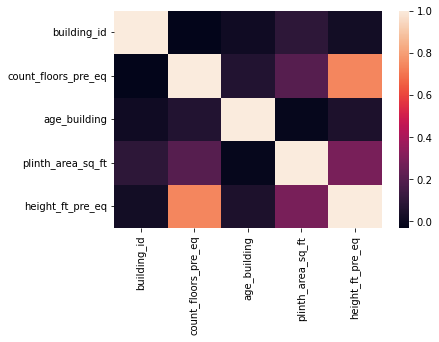

In [27]:
# Plot a correlation heatmap of the remaining numerical features in df
sns.heatmap(correlation);

In [28]:
df["severe_damage"].corr(df["count_floors_pre_eq"])

0.002892630372575257

In [29]:
df["severe_damage"].corr(df["height_ft_pre_eq"])

-0.0384765908330203

In [30]:
# Write a wrangle function so that it drops the "count_floors_pre_eq" column

def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearlity columns
    drop_cols.append("count_floors_pre_eq")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [31]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


Before I build my model, I'm going to see if I can identify any obvious differences between houses that were severely damaged in the earthquake (`"severe_damage"==1`) those that were not (`"severe_damage"==0`). I will start with a numerical feature. 

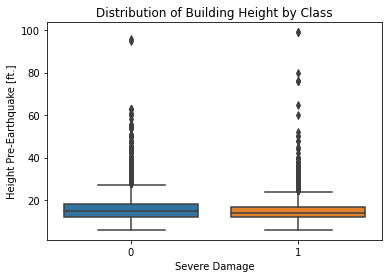

In [32]:
# Use seaborn to create a boxplot that shows the distributions of the "height_ft_pre_eq" column for both groups in the "severe_damage" column
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
# Label axes
plt.xlabel("Severe Damage")
plt.ylabel("Height Pre-Earthquake [ft.]")
plt.title("Distribution of Building Height by Class");

Before I move on to the many categorical features in this dataset, it's a good idea to see the balance between our two classes. I want to see what percentage were severely damaged and what percentage were not.

In [33]:
# Calculate the relative frequencies of the classes, not the raw count, so be sure to set the normalize argument to True
df["severe_damage"].value_counts(normalize=True)

1    0.642597
0    0.357403
Name: severe_damage, dtype: float64

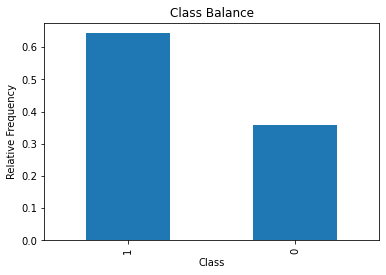

In [34]:
# Plot value counts of "severe_damage"
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Class", ylabel="Relative Frequency", title="Class Balance"); 

In [35]:
# Create two variables, majority_class_prop and minority_class_prop, to store the normalized value counts for the two classes in df["severe_damage"]
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(majority_class_prop, minority_class_prop)

0.6425969845841097 0.3574030154158902


Now I want to see if buildings with certain foundation types more likely to suffer severe damage.

In [36]:
# Create a pivot table of df where the index is "foundation_type" and the values come from the "severe_damage" column, aggregated by the mean
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


Question: How do the proportions in foundation_pivot compare to the proportions for our majority and minority classes? 

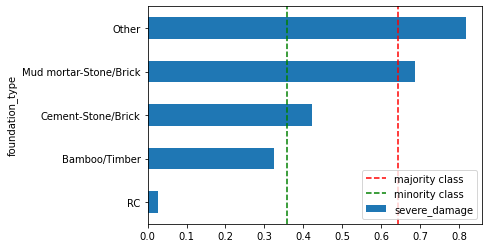

In [37]:
# Plot foundation_pivot as horizontal bar chart, adding vertical lines at the values for majority_class_prop and minority_class_prop
foundation_pivot.plot(kind="barh", legend=None)
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="majority class"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="minority class"
)
plt.legend(loc="lower right");

Combine the [`select_dtypes`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html) and [`nunique`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.nunique.html) methods to see if there are any high- or low-cardinality categorical features in the dataset. 

In [38]:
# Check for high- and low-cardinality categorical features
df.select_dtypes("object").nunique()

land_surface_condition     3
foundation_type            5
roof_type                  3
ground_floor_type          5
other_floor_type           4
position                   4
plan_configuration        10
superstructure            11
dtype: int64

In [39]:
df.head()

,building_id,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,,
164002,164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


In [40]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Create binary target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)
    
    # Drop old target
    drop_cols.append("damage_grade")
    
    # Drop multicollinearlity columns
    drop_cols.append("count_floors_pre_eq")
    
    # Drop high-cardinality categorical column
    drop_cols.append("building_id")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [41]:
df = wrangle("/home/jovyan/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


## Split

In [42]:
# Create my feature matrix X and target vector y
target = "severe_damage"    # My target is "severe_damage"
X = df.drop(columns=target)
y = df[target]

In [43]:
# Divide my data (X and y) into training and test sets using a randomized train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42             # My test set should be 20% of my total data & set a random_state for reproducibility
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (56668, 11)
y_train shape: (56668,)
X_test shape: (14168, 11)
y_test shape: (14168,)


# Build Model

## Baseline

In [44]:
# Calculate the baseline accuracy score for my model
y_train.value_counts()

1    36326
0    20342
Name: severe_damage, dtype: int64

In [45]:
y_train.value_counts(normalize=True)

1    0.641032
0    0.358968
Name: severe_damage, dtype: float64

In [46]:
y_train.value_counts(normalize=True).max()

0.6410319757182183

In [47]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Iterate

In [48]:
# Create a pipeline named model that contains a OneHotEncoder transformer and a LogisticRegression predictor

# Build model
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),   # Set the use_cat_names argument for my transformer to True
    LogisticRegression(max_iter=1000)
)
# Fit model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

## Evaluate

In [49]:
# Calculate the training and test accuracy scores for my models
accuracy_score(y_train, model.predict(X_train))

0.7138420272464178

In [50]:
model.score(X_test, y_test)

0.722261434217956

In [51]:
acc_train = accuracy_score(y_train, model.predict(X_train))
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

Training Accuracy: 0.71
Test Accuracy: 0.72


# Communicate

In [52]:
model.predict(X_train)[:5]

array([0, 1, 1, 1, 1])

In [53]:
# Instead of using the predict method with my model, I will try predict_proba with my training data
y_train_pred_proba = model.predict_proba(X_train)
print(y_train_pred_proba[:5])

[[0.96202945 0.03797055]
 [0.48938885 0.51061115]
 [0.34572677 0.65427323]
 [0.39497394 0.60502606]
 [0.33327859 0.66672141]]


In [54]:
# Extract the feature names and importances from my model
features = model.named_steps["onehotencoder"].get_feature_names()
importances = model.named_steps["logisticregression"].coef_[0]

In [55]:
# Create a pandas Series named odds_ratios
odds_ratios = pd.Series(np.exp(importances), index=features).sort_values()   # Index is features and the values are my the exponential of the importances
odds_ratios.head()

superstructure_Brick, cement mortar    0.260873
foundation_type_RC                     0.360797
roof_type_RCC/RB/RBC                   0.413654
ground_floor_type_RC                   0.485537
plan_configuration_Multi-projected     0.543422
dtype: float64

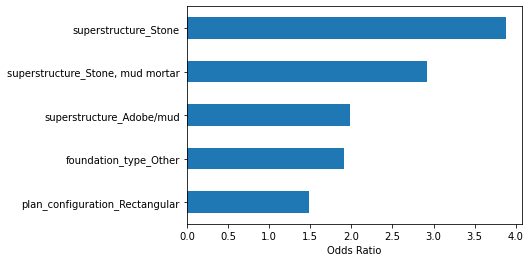

In [56]:
# Create a horizontal bar chart with the five largest coefficients from odds_ratios
odds_ratios.tail().plot(kind="barh")
plt.xlabel("Odds Ratio");   # Label my x-axis "Odds Ratio"

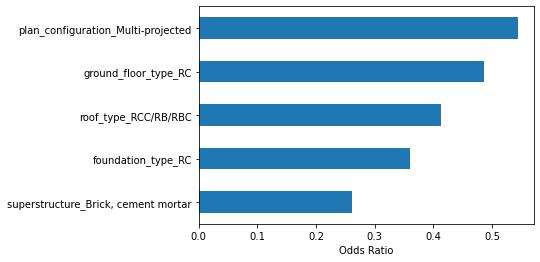

In [57]:
# Create a horizontal bar chart with the five smallest coefficients from odds_ratios
odds_ratios.head().plot(kind="barh")
plt.xlabel("Odds Ratio");   # Label my x-axis "Odds Ratio"